# notes
https://github.com/philzook58/egraphs2024-talk/blob/main/egraphs2024.pdf

- There was simplification.
- Brute Equational Search

# Egraphs and Automated Reasoning
### Looking Back to Look Forward

Philip Zucker

June 22, 2024


# Egraphs
- Congruence Closure
- e-nodes and e-classes
- 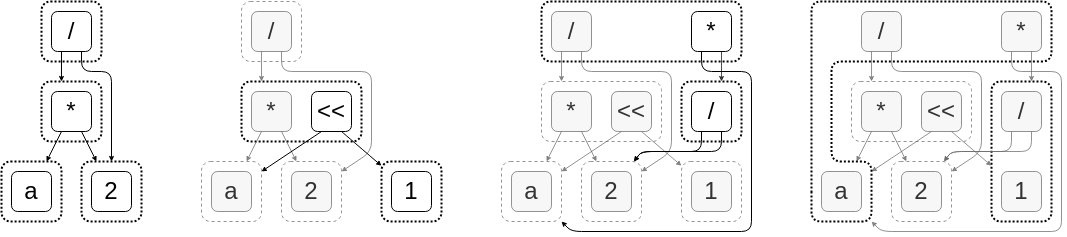
- Applications
- Compiler/Simplification focus
- Theorem Proving
- Operational
# Philosophy
- What is it about egg? Pictures + Compiler. Not a conceptual high bar to entry.
- Non completeness
- Limited scope leads to highly refined, fast, implementation

In the Beginning...

# SIMPLIFICATION

# Refinements
- Paramodulation - breadth first equational search of conditional equations
- Completion - Convert equations into good system
- Superposition - Combine properties of paramodulation and completion

# Completion
- Completion converts equations into confluent terminating rewrite systems
- Basic Completion
    + Orient equations
    + Find critical pairs
    + reduce


# Advanced Completion
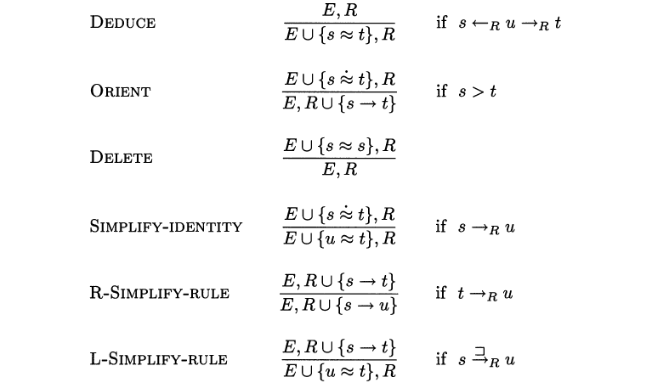

# The Main Point of The Talk
Egraphs are completed ground rewrite systems
Canonized Egraph = Canoninized GRS
- We have terms
- 

# Term Orderings
- Mostly getting a smaller term is better
- If terms keep shrinking, they have to stop.
- [Ground KBO](https://www.philipzucker.com/ground_kbo/)
- Term Orders correspond to objectives in e-graph Extraction
- Weights = Weights
- Extraction = Running the Rules


In [1]:
from enum import Enum
from z3 import *
Order = Enum("Order", ["LT", "EQ", "NGE", "GT"])
def kbo(t, r):
    pass

def size(t:ExprRef):
    return 1 + sum(size(x) for x in t.children())
def ground_kbo(t1, t2):
    if t1.eq(t2): # optimization
        return Order.EQ
    s1 = size(t1)
    s2 = size(t2)
    if s1 < s2:
        return Order.LT
    elif s1 > s2:
        return Order.GT
    else:
        if t1.num_args() < t1.num_args():
            return Order.LT
        elif t2.num_args() > t2.num_args():
            return Order.GT
        n1, n2 = t1.decl().name(), t2.decl().name()
        if n1 < n2:
            return Order.LT
        elif n1 > n2:
            return Order.GT
        else:
            for x,y in zip(t1.children(), t2.children()):
                o = ground_kbo(x,y)
                if o != Order.EQ:
                    return o
            assert False, "unreachable"

# Union Finds as Atomic Rewrite Systems
- Egraph is union find + hash cons
- Union finds can be seen as completed atomic rewrite systems
- Running the rewrite rules is calling `find`
- `union` is incrementally adding a new equation to R
- 


In [16]:
"""
def reduce_atom(a,R): # find
    while True:
        for (l,r) in R:
            if a.eq(l):
                a = r
        else:
            break
"""
import z3
# https://microsoft.github.io/z3guide/programming/Example%20Programs/Formula%20Simplification/
def subterms(t):
    seen = {}
    def subterms_rec(t):
        if z3.is_app(t):
            for ch in t.children():
                if ch in seen:
                    continue
                seen[ch] = True
                yield ch
                yield from subterms_rec(ch)
    return { s for s in subterms_rec(t) }
def is_subterm(t1,t2):
    return t1 in subterms(t2)
def apply_rules(e, R):
    e1 = z3.substitute(e, *R)
    while not e.eq(e1):
        e = e1
        e1 = z3.substitute(e, *R)
    return e

def critical_pairs(R):
    for (l1,r1) in R:
        for (l2,r2) in R:
            if is_subterm(l1, l2):
                #r2 = z3.substitute(l2, (l1, r1))
                r1 = apply_rules(r1, R)
                r2 = apply_rules(r2, R)
                if not r1.eq(r2):
                    yield r1, r2

def complete(R):
    while True:
        Rnew = []
        for a,b in critical_pairs(R):
            match ground_kbo(a,b):
                case Order.GT:
                    a,b = a,b
                case Order.LT:
                    a,b = b,a
                case Order.EQ:
                    pass
            Rnew.append((a,b))
        if len(Rnew) == 0:
            break
        R.extend(Rnew)
    return R
        

def union(a,b,R):
    a = apply_rules(a, R) #find
    b = apply_rules(b, R) #find
    match ground_kbo(a,b):
        case Order.GT:
            a,b = a,b
        case Order.LT:
            a,b = b,a
        case Order.EQ:
            return R
    R.append((a,b))
    return R

a,b,c,d,e = Ints("a b c d e")
R = []
union(b,a,R)
union(b,c,R)
union(a,c,R)
union(a,a,R)
union(b,d,R)
R
from IPython.display import display, Math
display(Math( r"\\".join(f"{a} \\rightarrow {b}" for a,b in R)))



<IPython.core.display.Math object>

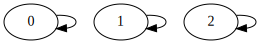

In [12]:
from graphviz import Digraph
class UF():
    def __init__(self):
        self.parent = []
    def find(self, x):
        while x != self.parent[x]:
           x = self.parent[x] 
        return x
    def makeset(self):
        n = len(self.parent)
        self.parent.append(n)
        return n
    def union(self, x, y):
        self.parent[self.find(x)] = self.find(y)
    def __repr__(self):
        return str(self.parent)
    def viz(self):
        dot = Digraph()
        for i, p in enumerate(self.parent):
            dot.edge(str(i), str(p))
        return dot
uf = UF()
zero = uf.makeset()
one = uf.makeset()
two = uf.makeset()

uf.viz()



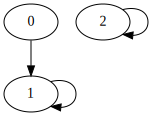

In [13]:
uf.union(zero, one)
uf.viz()

In [ ]:
from typing import Optional, Iterable, Dict
def match_(t : AstRef, pat : AstRef, vars : Iterable[ExprRef] = []) -> Optional[Dict[ExprRef,ExprRef]]:
    subst = {}
    todo = [(t,pat)]
    while todo:
        t,pat = todo.pop()
        if pat in vars or is_var(pat): # allow var as pattern?
            if pat in subst:
                if subst[pat].eq(t):
                    pass
                else:
                    return None
            else:
                subst[pat] = t
        elif isinstance(t, QuantifierRef) or isinstance(pat, QuantifierRef):
            raise NotImplementedError
        else:
            thead, targs = t.decl(), t.children()
            phead, pargs = pat.decl(), pat.children()
            if thead != phead or len(targs) != len(pargs): # check sorts here? The decl might check that
                return None
            todo.extend(zip(targs, pargs))
    return subst

E = DeclareSort("Expr")
foo = Function("foo", E, E, E)
bar = Function("bar", E, E)
a,b,c = Consts("a b c", E)
x,y,z = Consts("x y z", E)
vars = {x,y,z}

assert match_(foo(x, bar(y)), foo(a, bar(b)), vars) == None
assert match_(foo(a, bar(b)), foo(x, bar(y)), vars) == {x:a, y:b}
assert match_(foo(a, bar(b)), foo(a, bar(b)), vars) == {}
assert match_(foo(a, bar(b)), foo(x,x), vars) == None
assert match_(foo(a, bar(a)), foo(x,bar(x)), vars) == {x:a}
match_(foo(a, bar(a)), Lambda([x],foo(x,bar(x))).body()) == {Var(0, E):a}

In [5]:
from z3 import *
a = BitVec("a", 32)

e = (a * 2) / 2
e1 = (a << 1) / 2

a * 2 == a << 1
(a * 2) / 2 == a


E = [
    (a * 2, a << 1),
    ((a * 2) / 2, a)
]
# what else might be a good example?

# a + b + c
# a + b + a + b


<head>a| {}
<head>b| {}
<head>b| {}
<head>c| {}
<head>d| {}
<head>e| {}
<head>+| {<p0>0|<p1>1}
<head>c| {}
<head>+| {<p0>0|<p1>1}
<head>d| {}


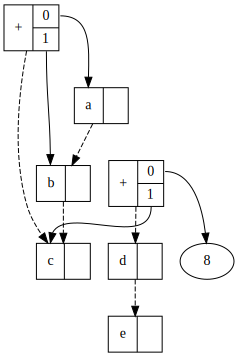

In [32]:
import graphviz
def node(e):
    return str(e.get_id())

def graphviz_of_z3(e, dot):
    label = "<head>" + e.decl().name() + "| {" + "|".join([ f"<p{n}>{n}" for n in range(e.num_args())]) + "}"
    print(label)
    dot.node(node(e), label, shape="record") # id?
    for n,c in enumerate(e.children()):
        dot.edge(node(e) + ":p" + str(n) , node(c) + ":head")

def show_rewrite(R):
    dot = graphviz.Digraph()
    for l,r in R:
        dot.edge(node(l), node(r), style="dashed")
        graphviz_of_z3(l,dot)
        graphviz_of_z3(r,dot)
    return dot
        
from z3 import *
a,b,c,d,e = Consts("a b c d e", IntSort())

show_rewrite([(a,b), (b,c), (d,e), (a  + b, c), (a-b+c, d)])

# Extending To Terms

- Visualization
  + subterm arrows
  + simplification arrows

# "Skolemization"

dd

# Tree Automata
- Strings ~ single argument terms
- Term rewriting formulation of DFA
- Generalizes to Tree

# Ematching and Strategies


# Resolution
- Resolution
- Ordered Resolution
- Datalog
- Prolog

note: have box that like fills in? Left side is propositional, right is equational. 
not a \/ b === a -> b

# Strategies
- Set of Support
- UR-resolution

# Equations
  
  paramodulation
- Superposition
- Egglog
- Functional Logic Programming

| Prop | Equational |
|------|------------|
| Resolution     |   Paramodulation         |
| Ordered Resolution | Superposition |
| ?  | Completion |
| Prolog | Functional Logic Programming |
| Datalog | Egglog |
| Lambda Prolog | ? |
| Hypothetical Datalog | ? |



- Handbook of automated reasononig
- Term Rewriting and All That
- Automated Reasoning: An Introduction

# Mysteries
I've noted before it isn't obvious what goes into the box next to completion in the propositional case

Ground atomic superposition is a contextual union find.


? = completion
lambda prolog = ?
hilog = ?
contextual datalog = ?
hypothetical prolog = ?

- Combining Rewrite Rules and Ground Equations. Combination problems.
- When is it ok to combine ground rules and equations? Combination problems

Grobner is ground equations modulo rings. 

Lambda Term Orderings are not that well behaved

- Lambda Term Orderings
- SKI
- Lambda Free



Greedy:
- Missed optimizations
- Ordering of rules matters
- Hard to reason about
- Nontermination

Problems:
- Brute search is very explosive

In [ ]:
def simplify1(t : Term) -> Term:


# Bits and Bobbles

Slides from juptyer?  I can nbconvert


Animations?